# Imports

In [1]:
!pip install pytabkit    

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.0/364.0 kB 8.1 MB/s eta 0:00:00


In [2]:
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from pytabkit import RealMLP_TD_Classifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

warnings.filterwarnings('ignore')

# Global Configuration

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_STATE = 42
N_FOLDS = 5
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
import torch
print(f"GPU数量: {torch.cuda.device_count()}")
print(f"当前默认设备: {torch.cuda.current_device()}")
print(f"显卡名称: {torch.cuda.get_device_name(0)}")

GPU数量: 2
当前默认设备: 0
显卡名称: Tesla T4


# Data Loading and Preprocessing

In [5]:
train = pd.read_csv("/kaggle/input/playground-series-s6e2/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s6e2/test.csv")
original = pd.read_csv("/kaggle/input/datasets/wangxintong111/heartdisease/Heart_Disease_Prediction.csv") 

le = LabelEncoder()
train['Heart Disease'] = le.fit_transform(train['Heart Disease'])
original['Heart Disease'] = le.fit_transform(original['Heart Disease'])

base_features = [col for col in train.columns if col not in ['Heart Disease', 'id']] 

def add_engineered_features(df):
    df_temp = df.copy()
    
    for col in base_features: 
        if col in original.columns:
           
            stats = original.groupby(col)['Heart Disease'].agg(['mean', 'median', 'std', 'skew', 'count']).reset_index()
         
            stats.columns = [col] + [f"orig_{col}_{s}" for s in ['mean', 'median', 'std', 'skew', 'count']]
     
            df_temp = df_temp.merge(stats, on=col, how='left') 
 
            fill_values = {
                f"orig_{col}_mean": original['Heart Disease'].mean(),
                f"orig_{col}_median": original['Heart Disease'].median(),
                f"orig_{col}_std": 0,
                f"orig_{col}_skew": 0,
                f"orig_{col}_count": 0
            }
            df_temp = df_temp.fillna(value=fill_values)
            
    return df_temp

train = add_engineered_features(train)
test = add_engineered_features(test) 

X = train.drop(['id', 'Heart Disease'], axis=1)
y = train['Heart Disease']
X_test = test.drop(['id'], axis=1)

# Data Quality Check (Missing & Duplicates)

In [6]:
def check_data_quality(df, name="Dataset"):
    print(f"--- Data Quality: {name} ---")
    print(f"Total Rows: {len(df)}")

    cols_to_check = [c for c in df.columns if c != 'id']
    dupes = df.duplicated(subset=cols_to_check).sum()

    nan_counts = df.isnull().sum()
    total_nans = nan_counts.sum()
    
    print(f"Duplicate Rows (excl. ID): {dupes}")
    print(f"Total NaN values: {total_nans}")
    if total_nans > 0:
        print("\nColumns with NaNs:")
        print(nan_counts[nan_counts > 0])
    print("-" * 30)

check_data_quality(train, "Train")
check_data_quality(test, "Test")

--- Data Quality: Train ---
Total Rows: 630000
Duplicate Rows (excl. ID): 0
Total NaN values: 0
------------------------------
--- Data Quality: Test ---
Total Rows: 270000
Duplicate Rows (excl. ID): 0
Total NaN values: 0
------------------------------


# Feature Uniqueness & Cardinality

In [7]:
def analyze_uniqueness(df):
    unique_stats = []
    for col in df.columns:
        if col == 'id': continue
        
        n_unique = df[col].nunique()
        dtype = df[col].dtype

        category_guess = "Categorical/Ordinal" if n_unique < 25 else "Continuous"
        
        unique_stats.append({
            'Feature': col,
            'Unique Values': n_unique,
            'Data Type': dtype,
            'Heuristic Type': category_guess
        })
    
    return pd.DataFrame(unique_stats).sort_values(by='Unique Values')

uniqueness_df = analyze_uniqueness(train)
print(uniqueness_df)

                     Feature  Unique Values Data Type       Heuristic Type
40  orig_FBS over 120_median              1   float64  Categorical/Ordinal
1                        Sex              2     int64  Categorical/Ordinal
13             Heart Disease              2     int64  Categorical/Ordinal
5               FBS over 120              2     int64  Categorical/Ordinal
20           orig_Sex_median              2   float64  Categorical/Ordinal
..                       ...            ...       ...                  ...
0                        Age             42     int64           Continuous
3                         BP             66     int64           Continuous
9              ST depression             66   float64           Continuous
7                     Max HR             93     int64           Continuous
4                Cholesterol            150     int64           Continuous

[79 rows x 4 columns]


# Visualize Top Skewed Features

Top 6 Most Skewed Features (Absolute Values):
orig_EKG results_count   -15.613416
orig_EKG results_std       6.747575
orig_Slope of ST_count    -5.657311
orig_Thallium_std          4.472673
orig_BP_std               -4.174508
orig_Age_std              -3.145546
dtype: float64


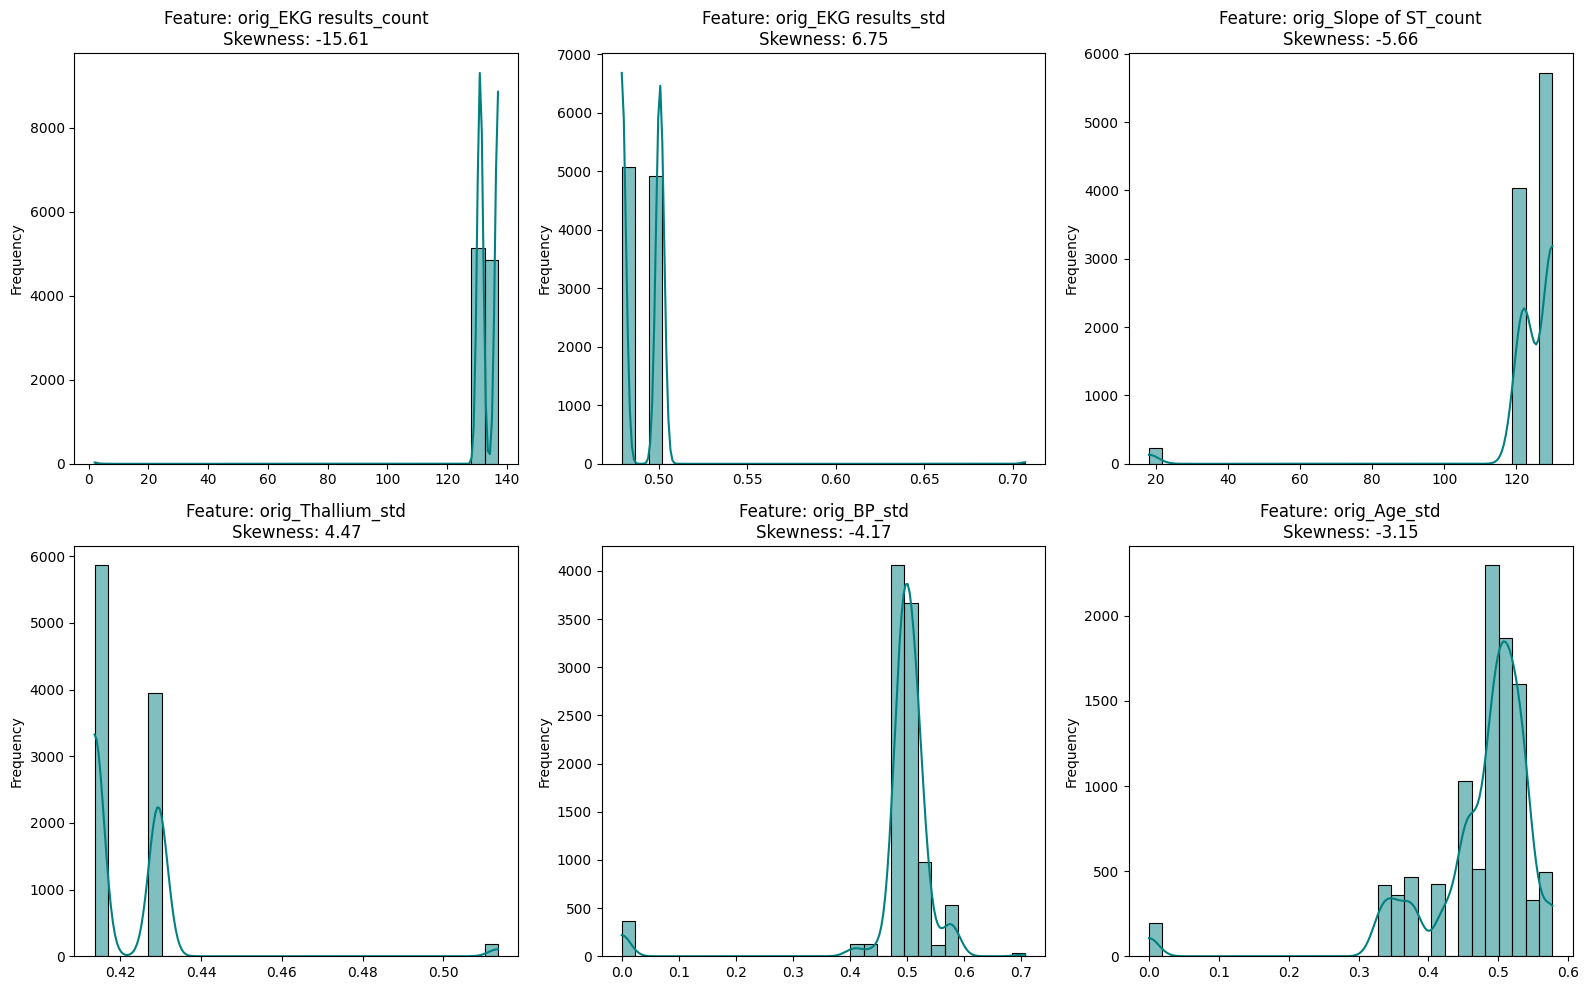

In [8]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

skew_series = X[numeric_cols].skew().abs().sort_values(ascending=False)
top_skewed_features = skew_series.head(6).index.tolist()

print("Top 6 Most Skewed Features (Absolute Values):")
print(X[top_skewed_features].skew())

plt.figure(figsize=(16, 10))
for i, col in enumerate(top_skewed_features):
    plt.subplot(2, 3, i + 1) 
    sns.histplot(X[col].sample(min(10000, len(X))), kde=True, color='teal', bins=30)
    plt.title(f"Feature: {col}\nSkewness: {X[col].skew():.2f}")
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig('skewed_distributions.png')

# Cross-Validation & Training

In [9]:
%%time
import torch
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed

# 1. 环境检查
n_gpus = torch.cuda.device_count()
print(f"🟢 Detected {n_gpus} GPUs. Mode: {'Parallel' if n_gpus > 1 else 'Sequential'}")

# 2. 基础参数
param_grid = {
    'random_state': 42,
    'verbosity': 1, 
    'n_epochs': 100,
    'batch_size': 512, 
    'n_ens': 8, 
    'use_early_stopping': True,
    'early_stopping_additive_patience': 20,
    'early_stopping_multiplicative_patience': 1,
    'act': "mish",
    'embedding_size': 8,
    'first_layer_lr_factor': 0.5962121993798933,
    'hidden_sizes': "rectangular",
    'hidden_width': 384,
    'lr': 0.04, 
    'ls_eps': 0.011498317194338772,
    'ls_eps_sched': "coslog4",
    'max_one_hot_cat_size': 18,
    'n_hidden_layers': 4, 
    'p_drop': 0.07301419697186451,
    'p_drop_sched': "flat_cos",
    'plr_hidden_1': 16, 
    'plr_hidden_2': 8,
    'plr_lr_factor': 0.1151437622270563,
    'plr_sigma': 2.3316811282666916,
    'scale_lr_factor': 2.244801835541429,
    'sq_mom': 1.0 - 0.011834054955582318,
    'wd': 0.02369230879235962,
} 

# ==========================================
# 🌟 [INSERTED] S-Tier Medical Feature Engineering 
# ==========================================
# Logic from NEJM: 55-60 age window is the most critical for hypertension impact.
def add_s_tier_feature(df):
    df_eng = df.copy()
    # Find BP column regardless of name (BP or Resting Blood Pressure)
    bp_col = [c for c in df.columns if 'BP' in c or 'Pressure' in c][0]
    
    # Create the interaction: Age 55-60 AND High BP
    df_eng['Critical_Age_Hypertension'] = (
        (df_eng['Age'] >= 55) & (df_eng['Age'] < 60) & (df_eng[bp_col] >= 140)
    ).astype(int)
    return df_eng

# Apply before categorical conversion
X = add_s_tier_feature(X)
X_test = add_s_tier_feature(X_test)
print("✅ S-Tier medical feature 'Critical_Age_Hypertension' added.")
# ==========================================

# 3. 数据预处理
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# 此时新特征 'Critical_Age_Hypertension' 会被自动包含在这个循环中并转为 category
for col in X.columns:
    X[col] = X[col].astype(str).astype('category')
    X_test[col] = X_test[col].astype(str).astype('category') 

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# 4. 定义单个 Fold 的训练函数
def train_single_fold(fold, train_idx, val_idx):
    device_id = fold % n_gpus
    device = f'cuda:{device_id}'
    
    print(f"🚀 Fold {fold + 1} started on {device}...")
    
    fold_params = param_grid.copy()
    fold_params['device'] = device
    
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = RealMLP_TD_Classifier(**fold_params) 
    model.fit(X_tr, y_tr.values, X_val, y_val.values) 
    
    val_probs = model.predict_proba(X_val)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]
    
    score = roc_auc_score(y_val, val_probs)
    print(f"✅ Fold {fold + 1} finished on {device}. AUC: {score:.5f}")
    
    del model, X_tr, X_val, y_tr, y_val
    gc.collect()
    if device.startswith('cuda'):
        try:
            torch.cuda.set_device(device)
            torch.cuda.empty_cache()
        except:
            pass
            
    return val_idx, val_probs, test_probs, score

# 5. 并行执行
results = Parallel(n_jobs=n_gpus, backend="loky")(
    delayed(train_single_fold)(fold, train_idx, val_idx) 
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y))
)

# 6. 汇总结果
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))
fold_scores = []

for val_idx, val_probs, fold_test_probs, score in results:
    oof_preds[val_idx] = val_probs
    test_preds += fold_test_probs / N_FOLDS
    fold_scores.append(score)

print(f"\n" + "="*40)
print(f"Mean AUC: {np.mean(fold_scores):.5f}")
print("="*40)

🟢 Detected 2 GPUs. Mode: Parallel
✅ S-Tier medical feature 'Critical_Age_Hypertension' added.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - 


Mean AUC: 0.95565
CPU times: user 48.3 s, sys: 2.44 s, total: 50.8 s
Wall time: 25min 15s


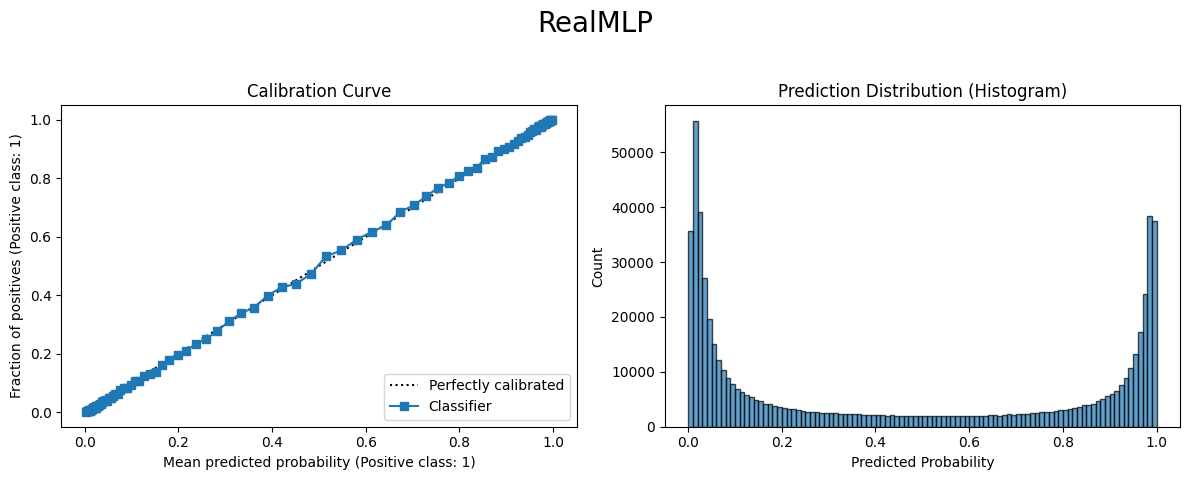

In [10]:
from sklearn.calibration import CalibrationDisplay

plt.figure(figsize=(12, 5)) 
plt.suptitle('RealMLP', fontsize=20) 

ax1 = plt.subplot(1, 2, 1)
CalibrationDisplay.from_predictions(y, oof_preds, n_bins=100, strategy='quantile', ax=ax1)
ax1.set_title('Calibration Curve')

ax2 = plt.subplot(1, 2, 2)
ax2.hist(oof_preds, bins=100, edgecolor='black', alpha=0.7)
ax2.set_title('Prediction Distribution (Histogram)')
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

# Evaluation and Submission

In [11]:
total_oof_score = roc_auc_score(y, oof_preds) 

print("\n" + "="*40)
print(f"Overall OOF ROC-AUC: {total_oof_score:.5f}")
print(f"Mean Fold Score: {np.mean(fold_scores):.5f} (+/- {np.std(fold_scores):.5f})")
print("="*40)

pd.DataFrame({'id': train['id'], 'Heart Disease_prob': oof_preds}).to_csv('oof.csv', index=False)

submission = pd.DataFrame({'id': test['id'], 'Heart Disease': test_preds})
submission.to_csv('submission.csv', index=False)
submission.head() 


Overall OOF ROC-AUC: 0.95558
Mean Fold Score: 0.95565 (+/- 0.00047)


,id,Heart Disease
0,630000,0.945413
1,630001,0.012765
2,630002,0.985761
3,630003,0.008294
4,630004,0.224556


# Baseline 
现在考虑了original的特征并加入了train作为了特征量
使用了frequency版的mlp



1. "Five risk factors account for approximately 50% of the global burden of cardiovascular disease. How the presence or absence of classic risk factors affects lifetime estimates of cardiovascular disease and death from any cause remains unclear."

"Lifetime risk of cardiovascular disease and death from any cause was estimated up to 90 years of age according to the presence or absence of arterial hypertension, hyperlipidemia, underweight and overweight or obesity, diabetes, and smoking at 50 years of age. Differences in life span (in terms of additional life-years free of cardiovascular disease or death from any cause) according to the presence or absence of these risk factors were also estimated."

"The lifetime risk of cardiovascular disease was 24% (95% confidence interval [CI], 21 to 30) among women and 38% (95% CI, 30 to 45) among men for whom all five risk factors were present. In the comparison between participants with none of the risk factors and those with all the risk factors, the estimated number of additional life-years free of cardiovascular disease was 13.3 (95% CI, 11.2 to 15.7) for women and 10.6 (95% CI, 9.2 to 12.9) for men; the estimated number of additional life-years free of death was 14.5 (95% CI, 9.1 to 15.3) for women and 11.8 (95% CI, 10.1 to 13.6) for men. As compared with no changes in the presence of all risk factors, modification of hypertension at an age of 55 to less than 60 years was associated with the most additional life-years free of cardiovascular disease, and modification of smoking at an age of 55 to less than 60 years was associated with the most additional life-years free of death."

"The absence of five classic risk factors at 50 years of age was associated with more than a decade greater life expectancy than the presence of all five risk factors, in both sexes. Persons who modified hypertension and smoking in midlife had the most additional life-years free of cardiovascular disease and death from any cause, respectively." 基于这个考虑扩张特征量

2. 用lgbm+mlp的混合模型
3. 现在age,BP, Cholesterol都label embedding了，再考虑一下是不是应该保留数值呢
4. 混合模型时考虑核心 trick：裁判模型不仅看 MLP 和 CatBoost 的预测值，还看原始数据的特征（Age, Sex...）。

原理：有时候，MLP 在某些特定年龄段（比如 60-70 岁）特别准，而 CatBoost 在年轻人中特别准。如果把原始特征（Age）也喂给裁判模型，裁判就能学会：“哦，这是一个 65 岁的病人，那我要多听 MLP 的意见；如果是个年轻人，我就听 CatBoost 的。”

Broccoli Beef 的代码演示了用 StackingClassifier(..., passthrough=True) 实现了这一点，并获得了分数的微弱提升。
 
